# B/W MNIST分析


各クラスごとに、
* 画素平均値算出
  通常平均
  重みづけ（中央優先）平均
* B/Wの各クラスごとのパーセンテージ
* 合計のパーセンテージ出力


In [1]:
!pip install sklearn
!pip install numpy
!pip install seaborn
# !pip install cufflinks

import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# import cufflinks as cf                       # おしゃれな可視化のために必要なライブラリ その2
 
# cf.go_offline()                              # cufflinksをオフラインで使うため

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def load_mnist(path, kind='train'):

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

def get_top_index(my_array:np.ndarray, K:int=3):
    # ソートはされていない上位k件のインデックス
    unsorted_max_indices = np.argpartition(-my_array, K)[:K]

    # 上位k件の値
    y = my_array[unsorted_max_indices]

    # 大きい順にソートし、インデックスを取得
    indices = np.argsort(-y)

    # 類似度上位k件のインデックス
    max_k_indices = unsorted_max_indices[indices]
    
    return max_k_indices

def get_bottom_index(my_array:np.ndarray, K:int=3):
    # ソートはされていない下位k件のインデックス
    unsorted_max_indices = np.argpartition(my_array, K)[:K]

    # 下位k件の値
    y = my_array[unsorted_max_indices]

    # 小さい順にソートし、インデックスを取得
    indices = np.argsort(y)

    # 類似度上位k件のインデックス
    max_k_indices = unsorted_max_indices[indices]
    
    return max_k_indices

# visualization
def draw_image(data, row, col, n, title:str = None):
    ax = plt.subplot(row, col, n)
    ax.axis("off")
    if title is not None:
        ax.set_title(title, fontdict={'fontsize':8})
    plt.imshow(data, cmap = "gray")

def draw_text(text, row, col, n):
    ax = plt.subplot(row, col, n)
    ax.axis("off")

    # build a rectangle in axes coords
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.text(0.5*(left+right), 0.5*(bottom+top), text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12, color='black',
        transform=ax.transAxes)

def plot_image(X_image, indexes, row=1, col=10):
    fig = plt.figure(figsize=(10, col+1))
    offset = 0
    for index in indexes:
        offset += 1
        draw_image(X_image[index].reshape(28,28), row, col, offset)
    plt.show()

def plot_hist_image(X_image, indexes, row=1, col=10):
    """ヒストグラム作成
    """
    
    fig = plt.figure(figsize=(10, 1))
    offset = 0
    for index in indexes:
        offset += 1

        # ヒストグラムの取得
        img_hist, _ = np.histogram(np.array(X_image[index]).flatten(), bins=np.arange(256+1))

        # ヒストグラムの表示
        ax = plt.subplot(row, col, offset)
        ax.axis("off")
        plt.plot(img_hist, color='black', linewidth = 1)
    plt.show()

    
def plot_image_and_hist(X_image, indexes, prefix, n_class, row=20, col=10):
   
    fig = plt.figure(figsize=(10, 20))
    fig.suptitle(f'{prefix} Analyze Class:{n_class}', fontsize=20, y=0.925)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    offset = 0
    for index in indexes:
        offset += 1

        # 画像表示
        draw_image(X_image[index].reshape(28,28), row, col, offset, str(index))

        # ヒストグラムの取得
        img_hist, _ = np.histogram(np.array(X_image[index]).flatten(), bins=np.arange(256+1))
        # ヒストグラムの表示
        ax = plt.subplot(row, col, offset+col)
        ax.axis("off")
        plt.plot(img_hist, color='black', linewidth = 1)

        if offset % col == 0:
            # ヒストグラム行を飛ばす
            offset += col

    plt.show()

# 画像中央を重視する重みを設定。
average_weight = np.array(
    [[0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
     [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
     [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
     [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
     [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
     [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
     [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
     [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
     [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
     [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
     [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
     [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
     [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4],
     [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4],
     [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4],
     [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4],
     [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
     [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
     [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
     [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
     [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
     [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
     [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
     [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
     [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
     [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
     [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
     [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1]]
     )


     |████████████████████████████████| 6.8 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 5.9 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=f7567ee4fcaf319cc26f3007e210f5ec145f5faf0cc8f2c8b3f9ddcdfd469ecc
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
     |████████████████████████████████| 215 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 10.5 MB 10.9 MB/s eta 0:00:01   |██████████▉                     | 3.6 MB 5.3 MB/s eta 0:00:02     |██████████████▌                 | 4.7 MB 5.3 MB/s eta 0:00:02
     |████████████████████████████████| 510 kB 5.0 MB/s eta 0:00:01


In [2]:
# load data

X_target, y_target = load_mnist('../data/Fashion-MNIST', kind='train')

# 前処理として、画像を最大値255で割って0.0 - 1.0に規格化する。
X_target_n = X_target / 255

print(type(X_target))
print(X_target.shape)

<class 'numpy.ndarray'>
(60000, 784)


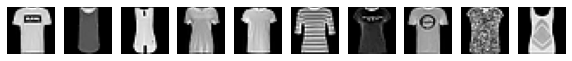

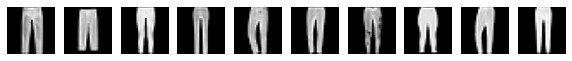

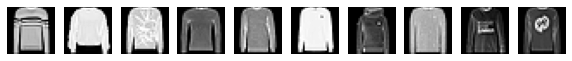

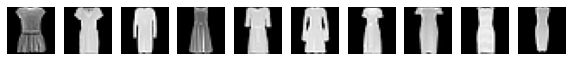

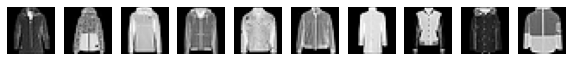

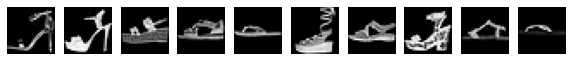

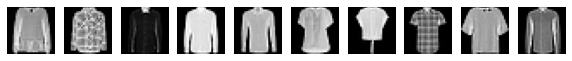

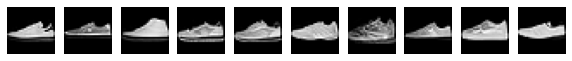

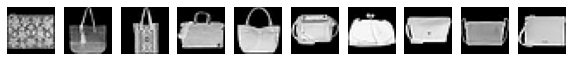

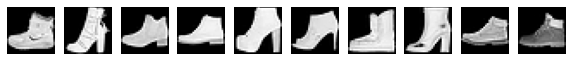

In [3]:
classes = np.unique(y_target)
target_indexes={}

# クラス分類
for c in classes:
    target_indexes[c] = np.where(y_target == c)[0]
    plot_image(X_target, target_indexes[c][0:10])

In [4]:
# 画素値（ノーマライズ）平均値
target_mean={}
target_means={}
target_stds={}

# 重みなし
for c in classes:
    target_means[c] = [X_target_n[i].mean() for i in target_indexes[c]]
    np_target_means = np.array(target_means[c])
    target_mean[c] = np_target_means.mean()
    target_stds[c] = np.std(np_target_means)

    print(f'target_mean[{c}] = {target_mean[c]}')
    print(f'std_target_mean[{c}] = {target_stds[c]}')
    
    print(len(np.where(target_means[c] > target_mean[c])[0]))
    print(len(np.where(target_means[c] <= target_mean[c])[0]))


target_mean[0] = 0.3256077664399093
std_target_mean[0] = 0.11337491460878117
3230
2770
target_mean[1] = 0.22290531462585034
std_target_mean[1] = 0.05695100874843013
2910
3090
target_mean[2] = 0.37670102957849805
std_target_mean[2] = 0.12803171246984676
3309
2691
target_mean[3] = 0.25889768073896224
std_target_mean[3] = 0.08390166815860088
3017
2983
target_mean[4] = 0.3853255118714152
std_target_mean[4] = 0.10363470863969469
3444
2556
target_mean[5] = 0.13673547669067626
std_target_mean[5] = 0.062098509945455425
2632
3368
target_mean[6] = 0.3317847839135654
std_target_mean[6] = 0.12973209619040815
3043
2957
target_mean[7] = 0.16769440109377085
std_target_mean[7] = 0.05033874611770128
2764
3236
target_mean[8] = 0.3535574621515273
std_target_mean[8] = 0.11281218281636766
2940
3060
target_mean[9] = 0.30119654278378016
std_target_mean[9] = 0.07176845957694927
2860
3140


In [5]:
# 重みあり
for c in classes:
    target_means[c] = [np.average(X_target_n[i], weights=average_weight.flatten()) for i in target_indexes[c]]
    np_target_means = np.array(target_means[c])
    target_mean[c] = np_target_means.mean()
    target_stds[c] = np.std(np_target_means)

    print(f'target_mean[{c}] = {target_mean[c]}')
    print(f'std_target_mean[{c}] = {target_stds[c]}')
    
    print(len(np.where(target_means[c] > target_mean[c])[0]))
    print(len(np.where(target_means[c] <= target_mean[c])[0]))


target_mean[0] = 0.3942406725023343
std_target_mean[0] = 0.13573093247743043
3270
2730
target_mean[1] = 0.28838001587301587
std_target_mean[1] = 0.06935125025866451
2992
3008
target_mean[2] = 0.4498409045284781
std_target_mean[2] = 0.15250771126301912
3361
2639
target_mean[3] = 0.3357971846405229
std_target_mean[3] = 0.10466197580054999
3072
2928
target_mean[4] = 0.4737242593370682
std_target_mean[4] = 0.12337204030554441
3565
2435
target_mean[5] = 0.1660121514939309
std_target_mean[5] = 0.07049382573740247
2641
3359
target_mean[6] = 0.40039711227824465
std_target_mean[6] = 0.15557921294619342
3078
2922
target_mean[7] = 0.22781988538748832
std_target_mean[7] = 0.06258696407473495
2852
3148
target_mean[8] = 0.42211301073762836
std_target_mean[8] = 0.12743950753642025
3044
2956
target_mean[9] = 0.3562116890756303
std_target_mean[9] = 0.07627905593984231
2943
3057


In [6]:
# a = np.arange(12).reshape((3, 4))
a = np.empty((11, 5))
print(a)

a[:1] = [100, 200, 300, 400, 500]
print(a)

# print(np.insert(a, 0, [100,200,300,400], axis=0))

[[2.62768537e-316 0.00000000e+000 9.76118065e-313 4.94065646e-324
  6.91547503e-310]
 [5.92878775e-323 6.91547503e-310 1.03977794e-312 0.00000000e+000
  0.00000000e+000]
 [6.36598739e-313 0.00000000e+000 1.08221785e-312 6.57818695e-313
  6.91547503e-310]
 [5.92878775e-323 6.91547503e-310 1.14587773e-312 0.00000000e+000
  0.00000000e+000]
 [1.50690022e-321 0.00000000e+000 1.18831764e-312 6.91537208e-310
  6.91547503e-310]
 [2.12199580e-314 6.91547503e-310 1.25197752e-312 4.66839074e-313
  0.00000000e+000]
 [1.50690022e-321 0.00000000e+000 1.29441743e-312 4.94065646e-324
  6.91547503e-310]
 [5.92878775e-323 6.91547503e-310 1.35807731e-312 0.00000000e+000
  0.00000000e+000]
 [1.50690022e-321 0.00000000e+000 1.40051722e-312 3.24249305e-086
  6.91547503e-310]
 [6.91548019e-310 6.91547503e-310 1.46417710e-312 0.00000000e+000
  0.00000000e+000]
 [2.61948314e-316 0.00000000e+000 1.50661701e-312 4.94065646e-324
  6.91547503e-310]]
[[1.00000000e+002 2.00000000e+002 3.00000000e+002 4.00000000e+00

In [43]:
import pandas as pd

csv_data = np.zeros((11, 5))

# 重みあり
for c in classes:
    target_means[c] = [np.average(X_target_n[i], weights=average_weight.flatten()) for i in target_indexes[c]]
    np_target_means = np.array(target_means[c])
    target_mean[c] = np_target_means.mean()
    target_stds[c] = np.std(np_target_means)
    
    csv_data[c] = [len(target_means[c]), 
                    target_mean[c], 
                    target_stds[c], 
                    len(np.where(target_means[c] > target_mean[c])[0]),
                    len(np.where(target_means[c] <= target_mean[c])[0])]

sums = np.sum(csv_data[0: len(classes)], axis=0)
means = np.mean(csv_data[0: len(classes)], axis=0)
csv_data[-1] = [sums[0], means[1], means[2], sums[3], sums[4]]

df = pd.DataFrame(csv_data,
                  columns=['data_num', 'mean', 'std', 'b_num', 'w_num'],
                  index=[x for x in [f'class_{c}' for c in classes]+['total']])

df
df.to_csv('bw_mnist.csv', header=True, index=True)

In [46]:


# x = [df['std'][f'class_{c}'] for c in classes]
x = [df['b_num'][f'class_{c}'] / df['w_num'][f'class_{c}'] for c in classes]
# x = [a for a in df['std']]
print(type(x))
print(x)

# print(df['std']['total'])
# print(df['w_num']['total'])


# print(df['b_num']['total'] / df['w_num']['total'])
# print(df['b_num']['class_0'] / df['w_num']['class_0'])


<class 'list'>
[1.1978021978021978, 0.9946808510638298, 1.2735884804850321, 1.0491803278688525, 1.4640657084188913, 0.7862459065197975, 1.053388090349076, 0.9059720457433291, 1.0297699594046008, 0.9627085377821394]


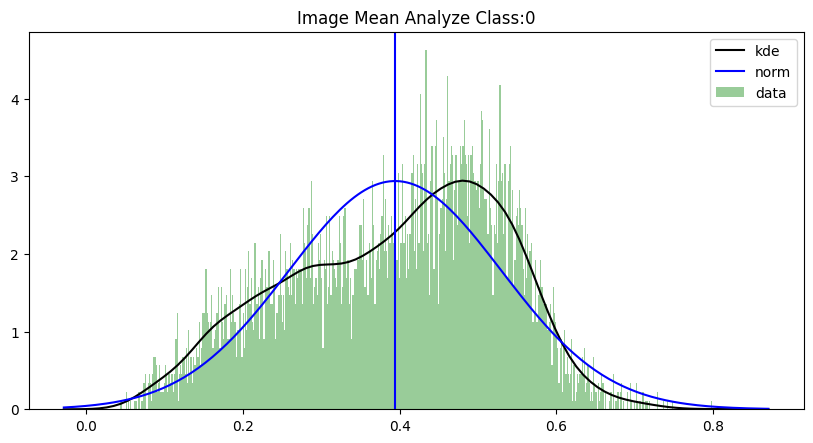

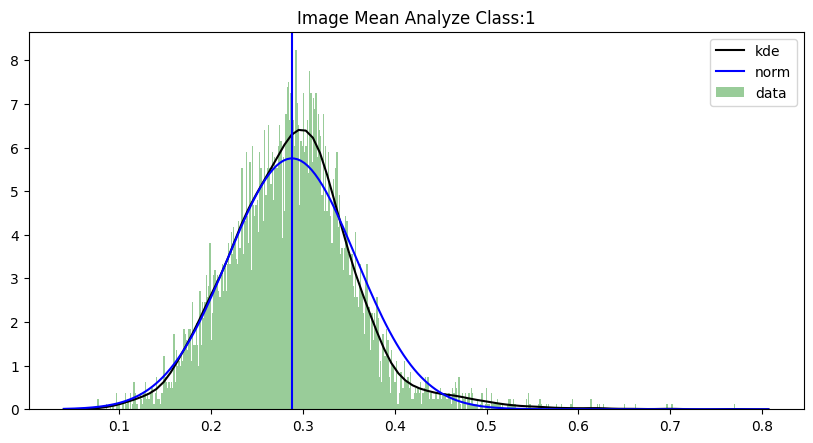

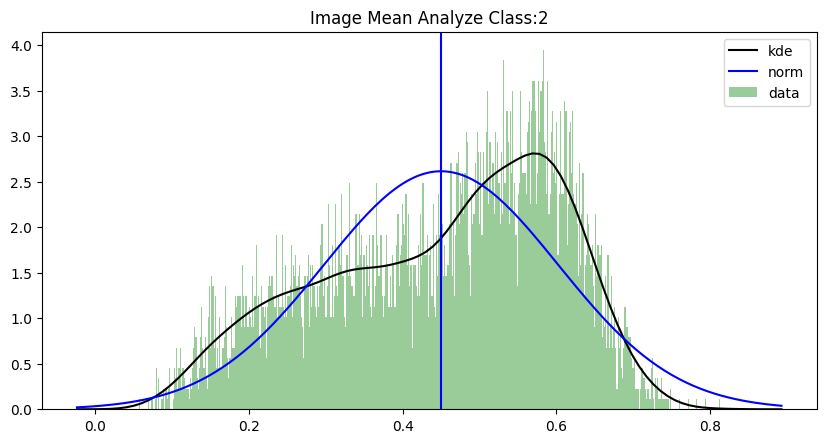

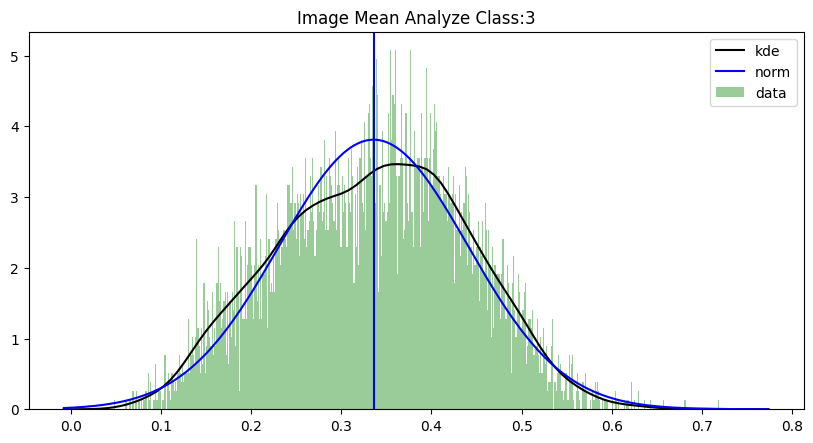

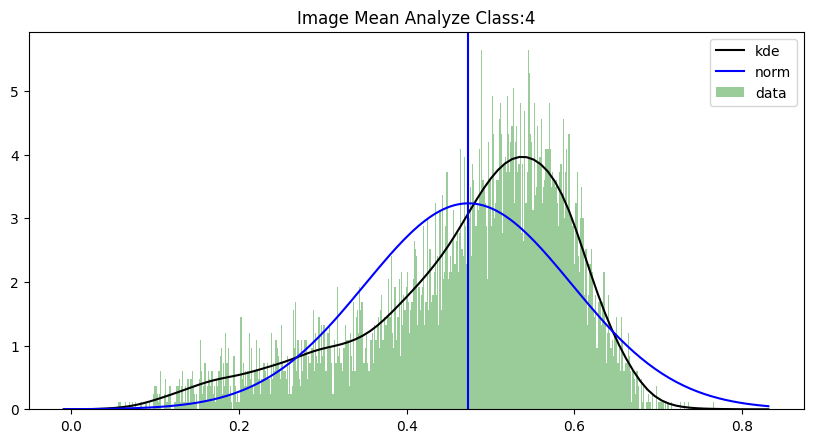

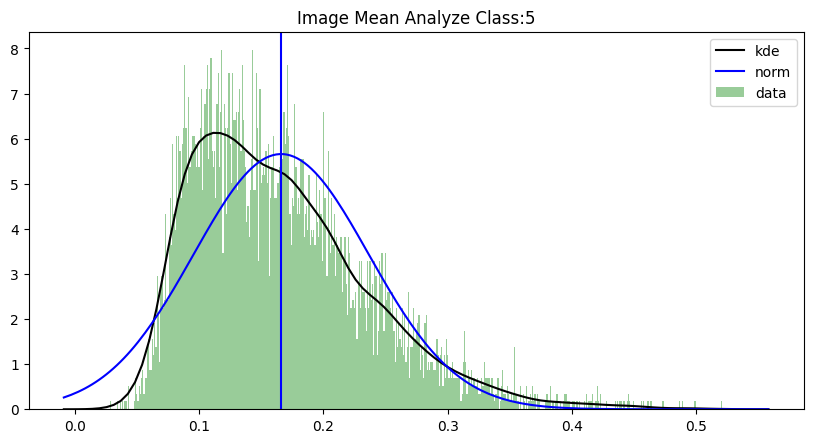

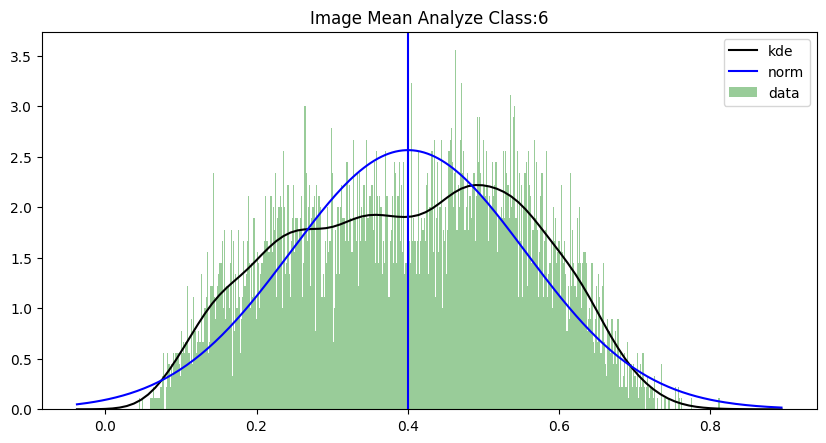

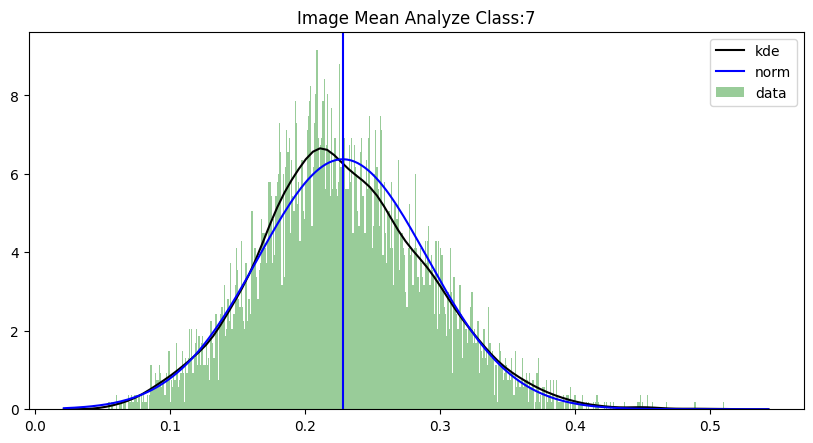

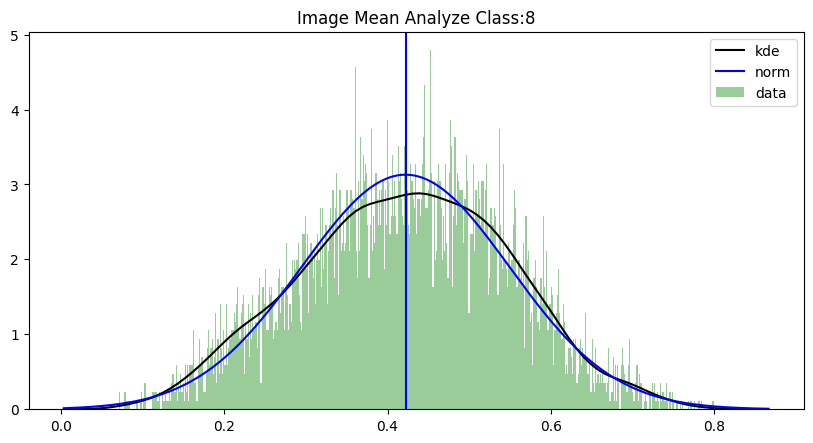

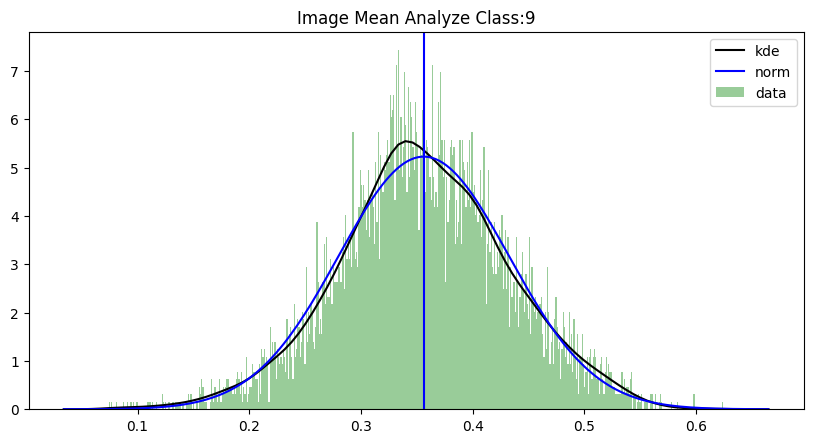

In [8]:
# 画素値ヒストグラム

# def plot_histgram(target_name, means, mean):
#     # sharey: Y軸合わせ
#     fig, ax = plt.subplots(classes.shape[0], 1, sharey=True, figsize=(20,80))
#     plt.subplots_adjust(wspace=0, hspace=0.6)

#     for c in classes:
#         ax[c].set_title(f'{target_name}: Image Mean Analyze Class:{c}')
#         sns.distplot(means[c],
#                      bins=min(512, np.unique(target_means[0]).size),
#                      hist_kws={'color':'green','label':"data"},
#                      kde=True,
#                      kde_kws={'color': 'black', 'label': 'kde'}, 
#                      fit=stats.norm,
#                      fit_kws={'color': 'blue', 'label': 'norm'},
#                      ax=ax[c])
#         ax[c].axvline(x=float(mean[c]), ymin=0, ymax=len(means[c]), color='blue')

def plot_histgram(means, mean):

    for c in classes:
        fig = plt.figure(figsize=(10,5),dpi=100)
        plt.title(f'Image Mean Analyze Class:{c}')
        sns.distplot(means[c],
                     bins=min(512, np.unique(target_means[0]).size),
                     hist_kws={'color':'green','label':"data"},
                     kde=True,
                     kde_kws={'color': 'black', 'label': 'kde'}, 
                     fit=stats.norm,
                     fit_kws={'color': 'blue', 'label': 'norm'})
        plt.axvline(x=float(mean[c]), ymin=0, ymax=len(means[c]), color='blue')
        plt.legend()
        plt.show()
#         plt.savefig(f'histgram_{c}.png')
        
plot_histgram(means=target_means, mean=target_mean)

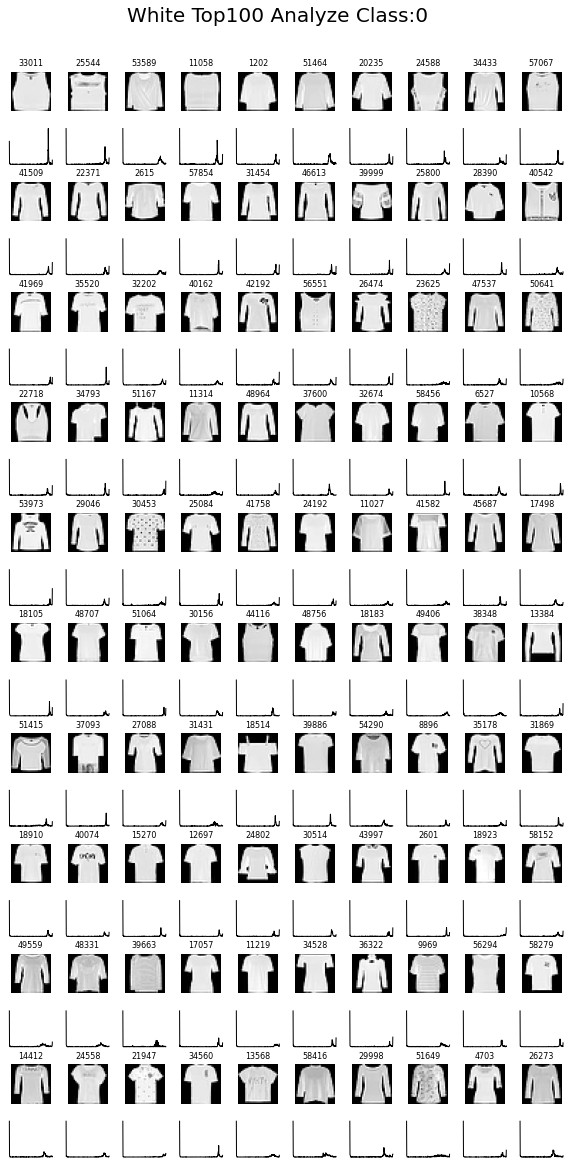

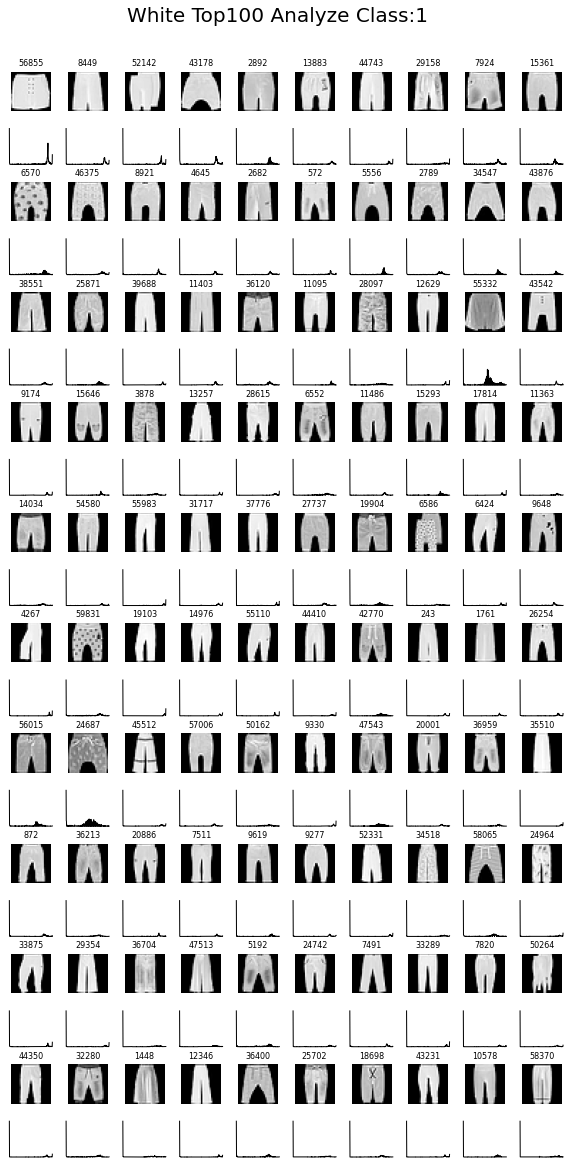

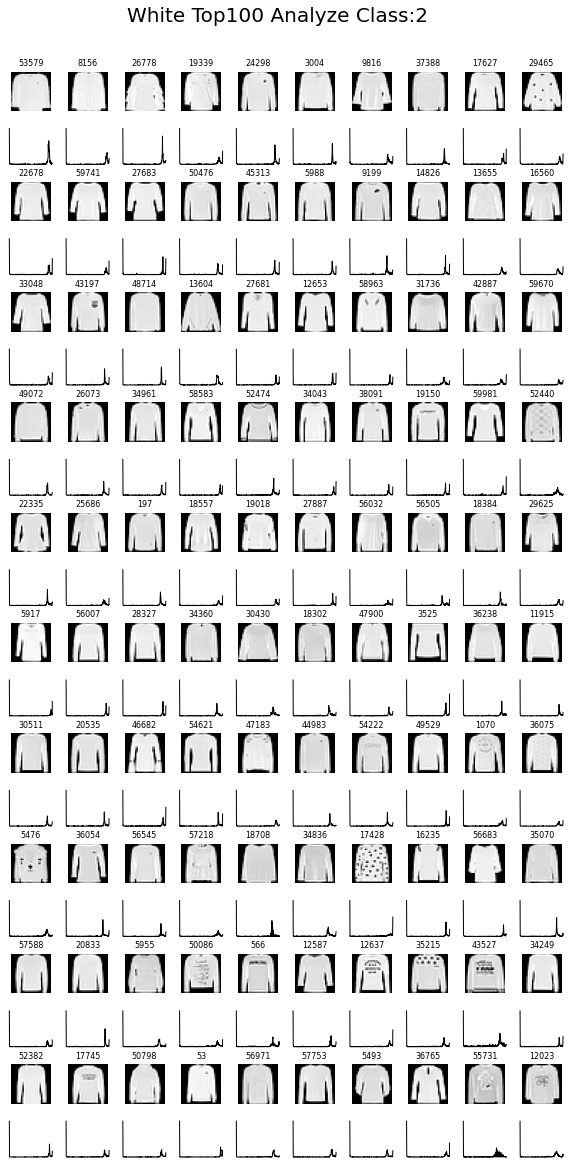

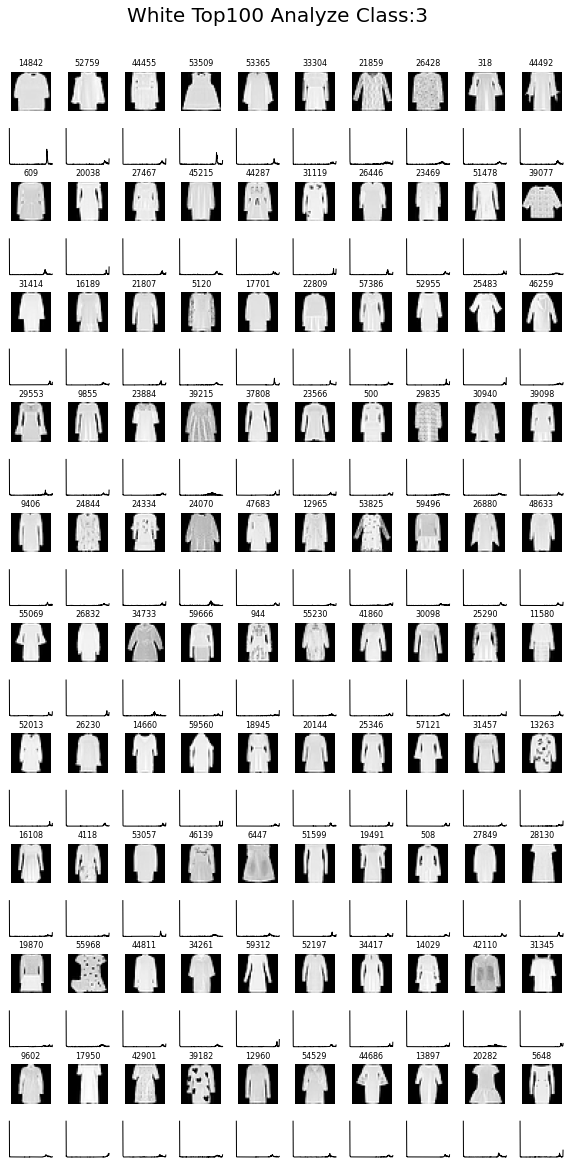

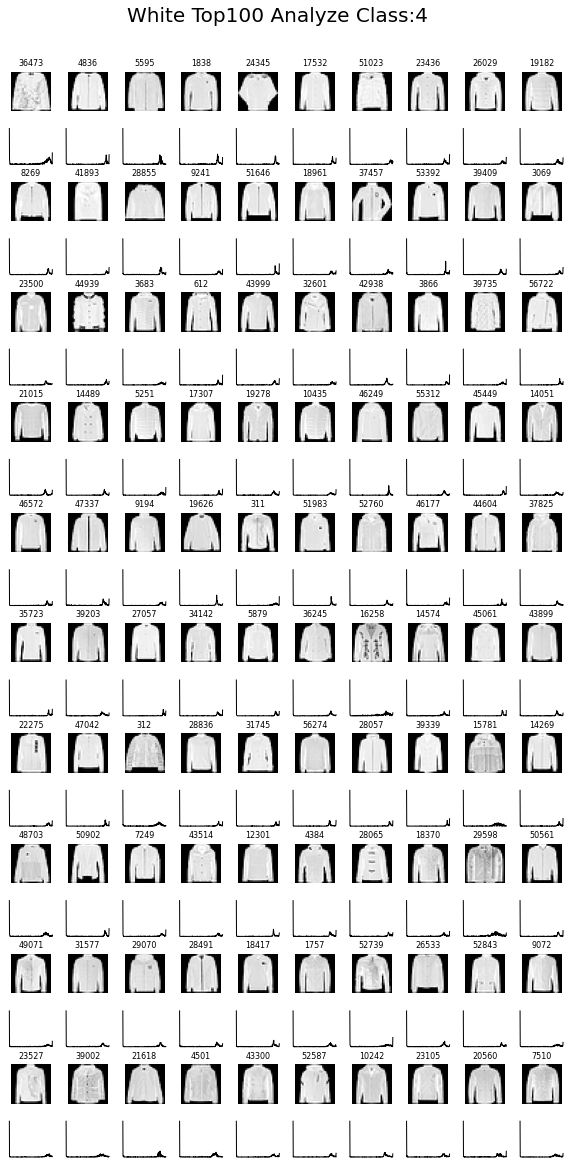

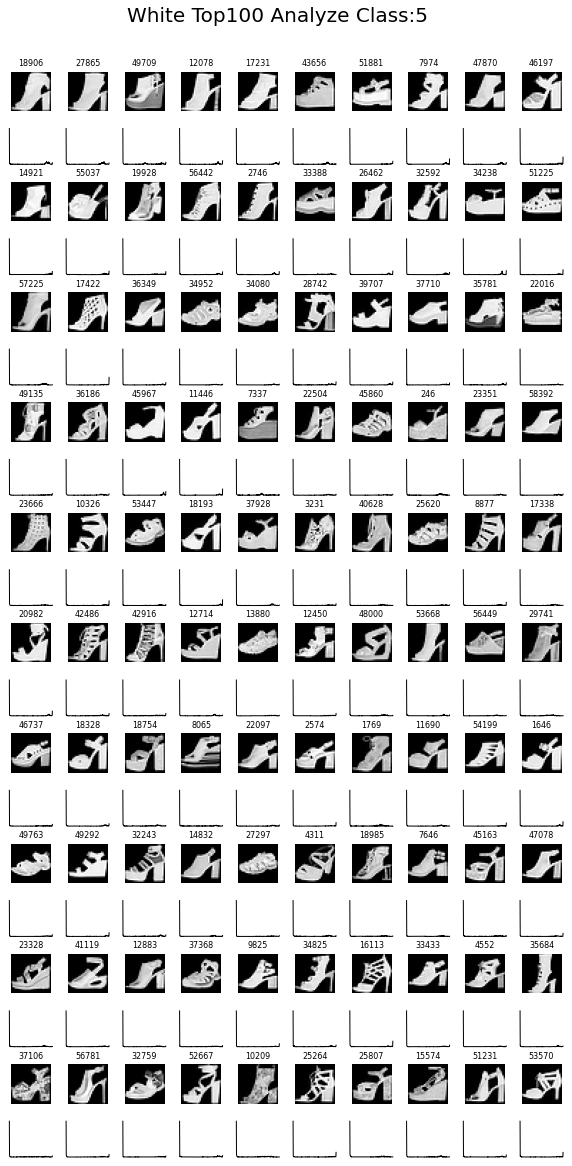

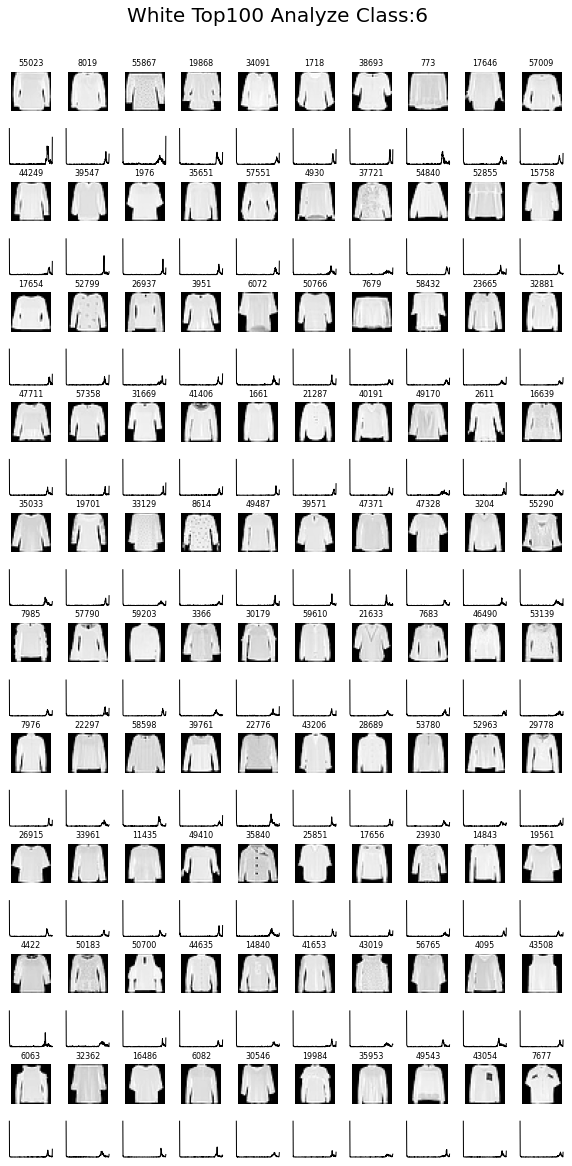

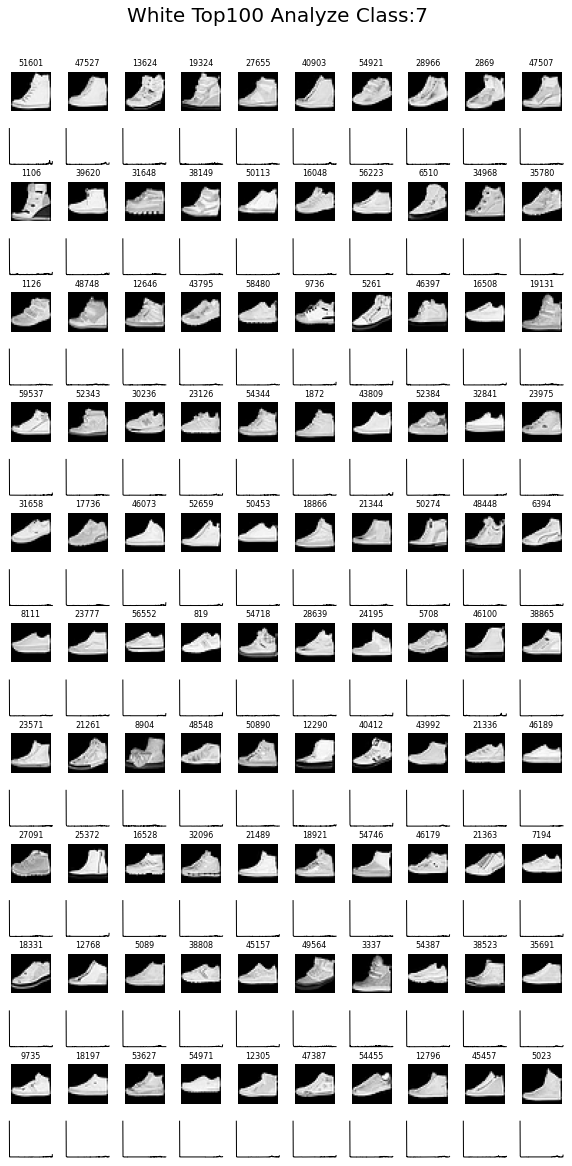

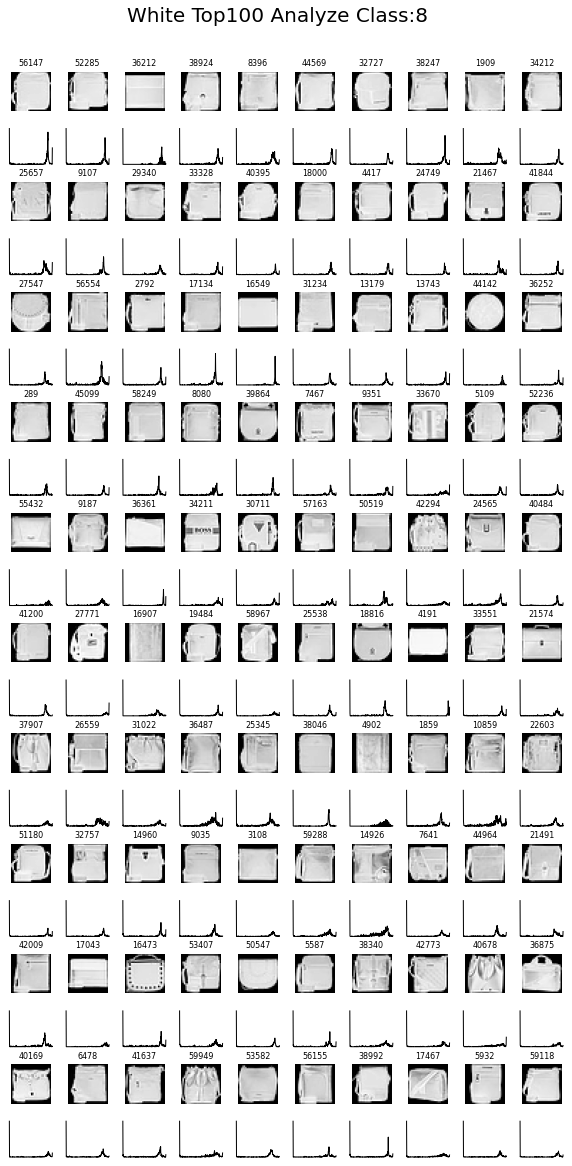

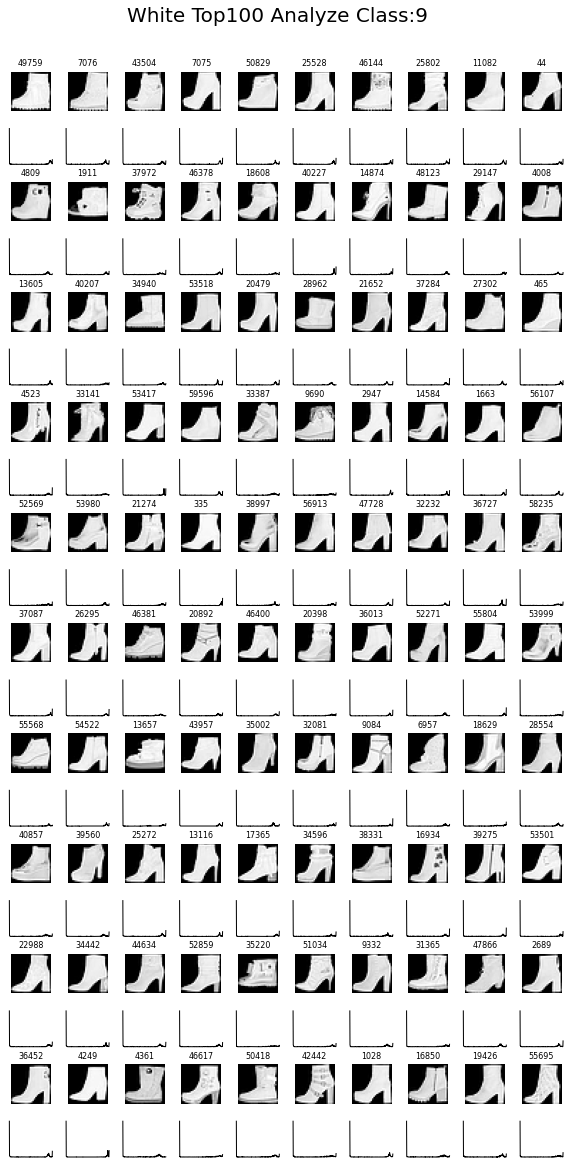

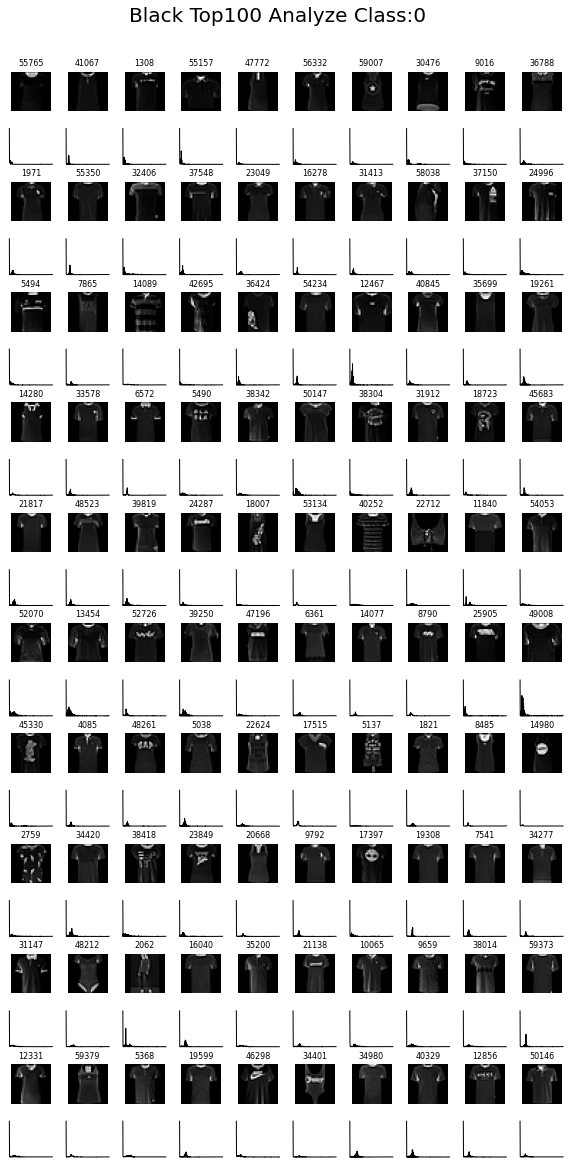

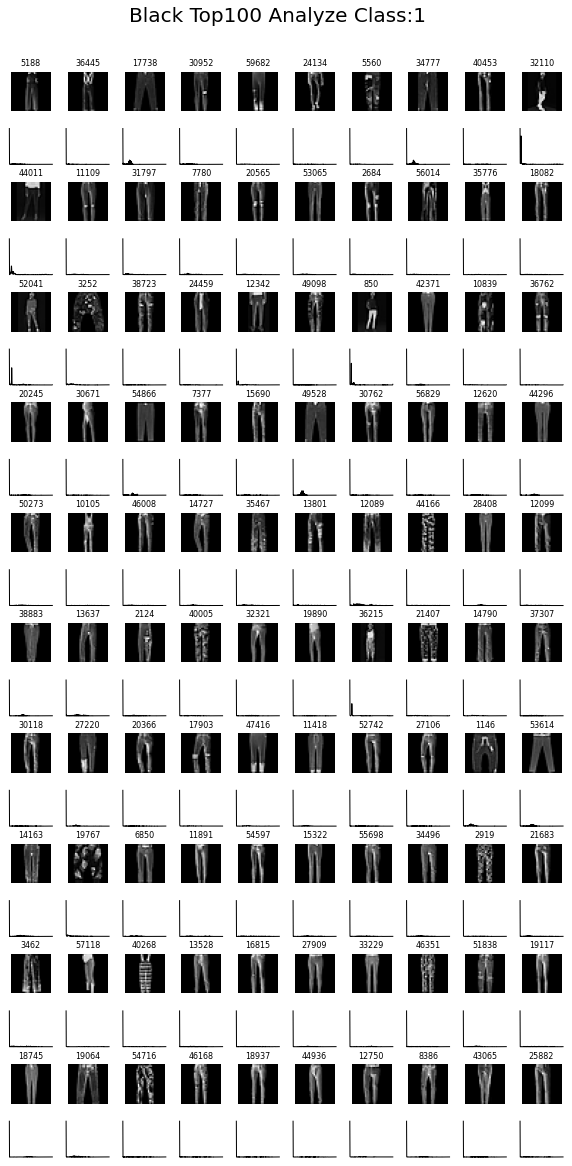

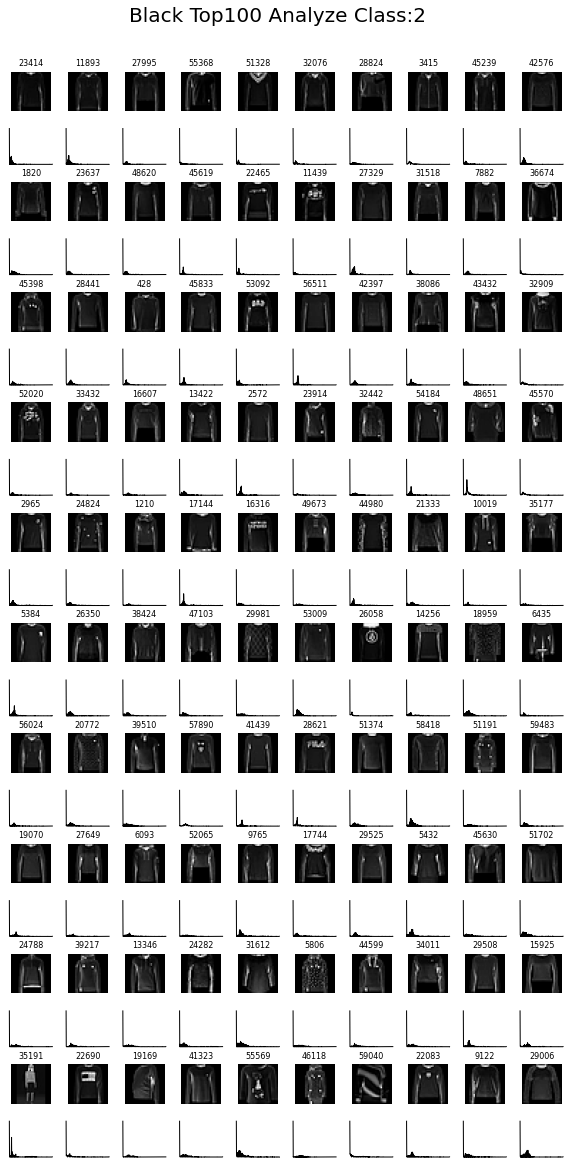

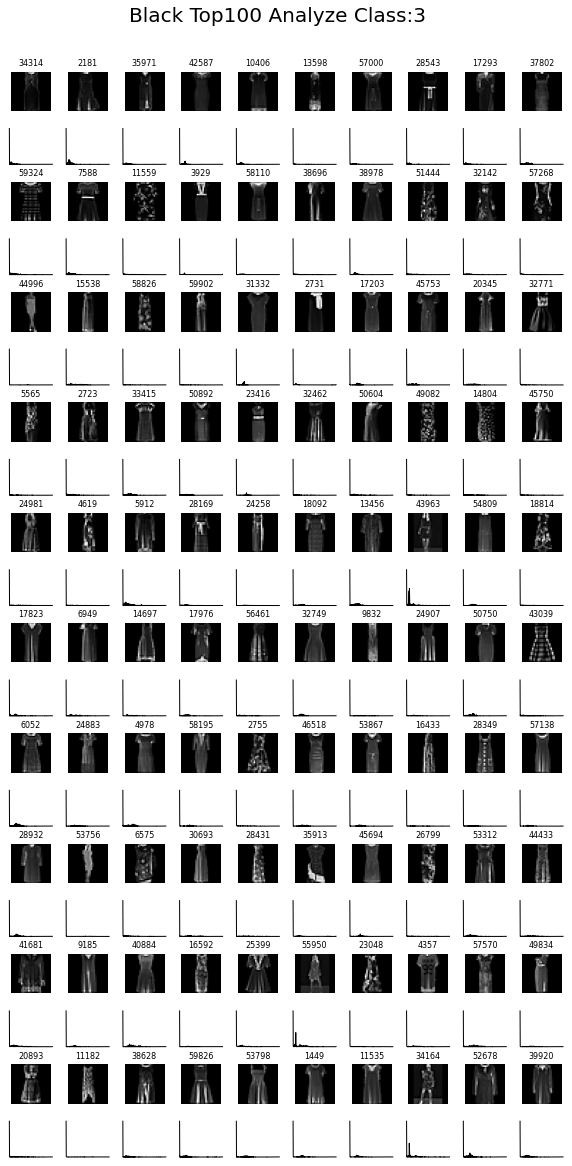

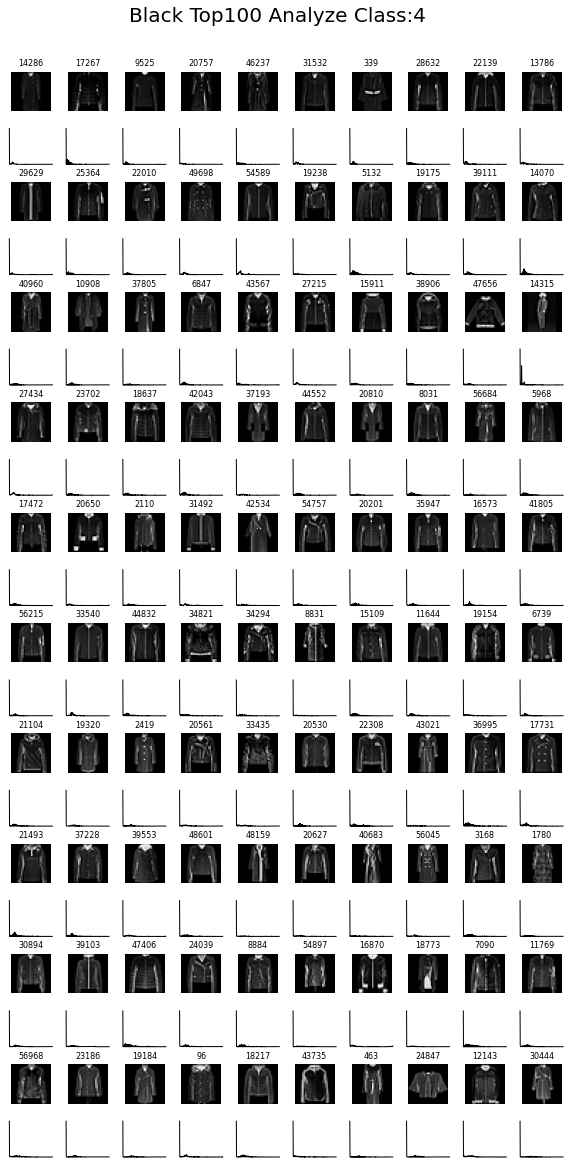

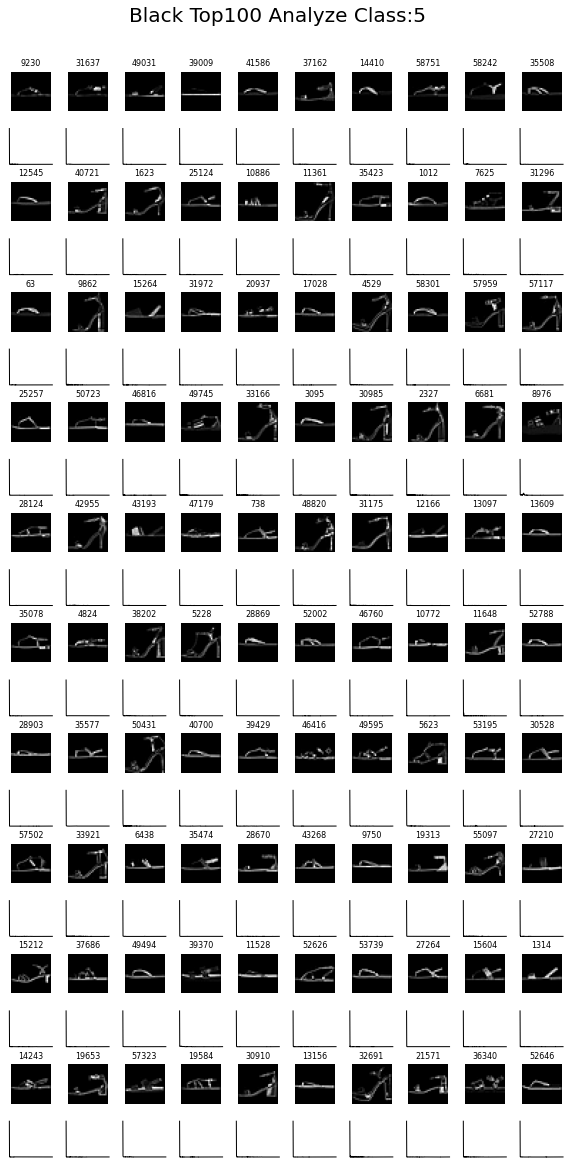

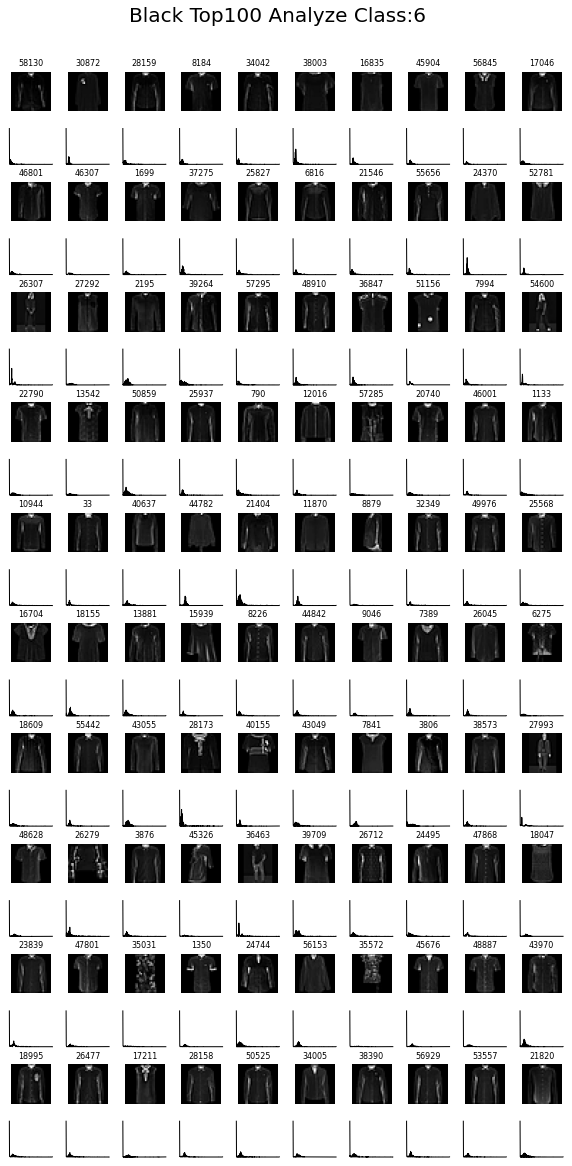

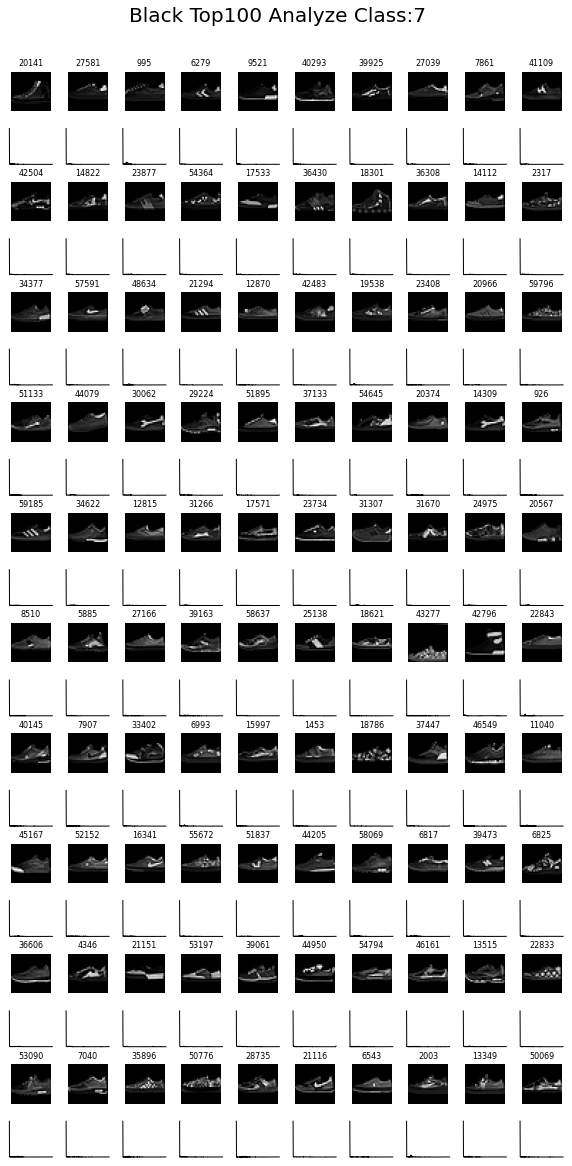

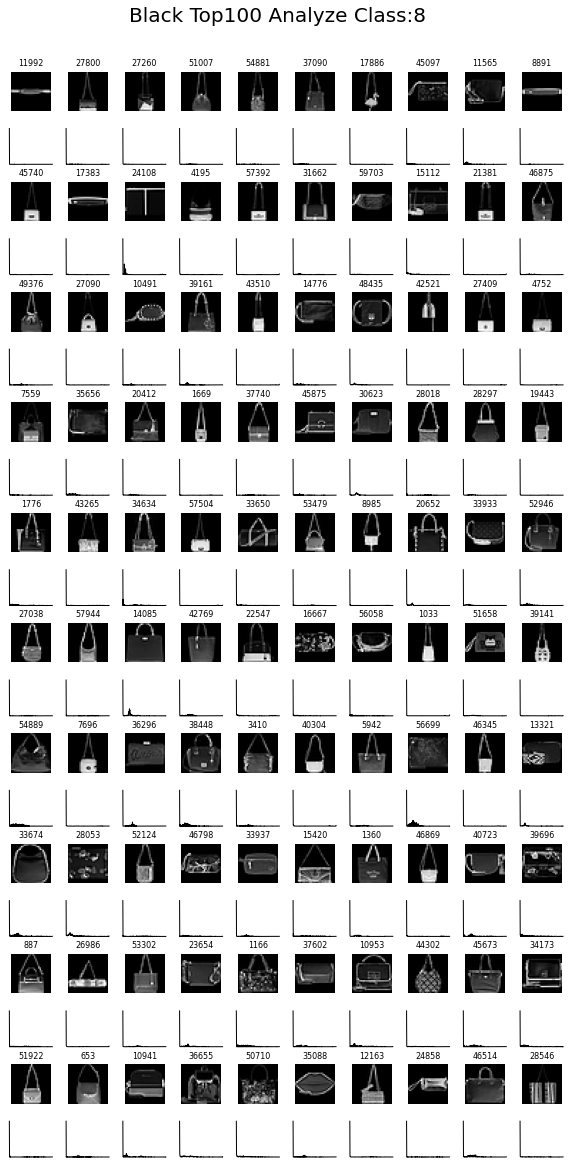

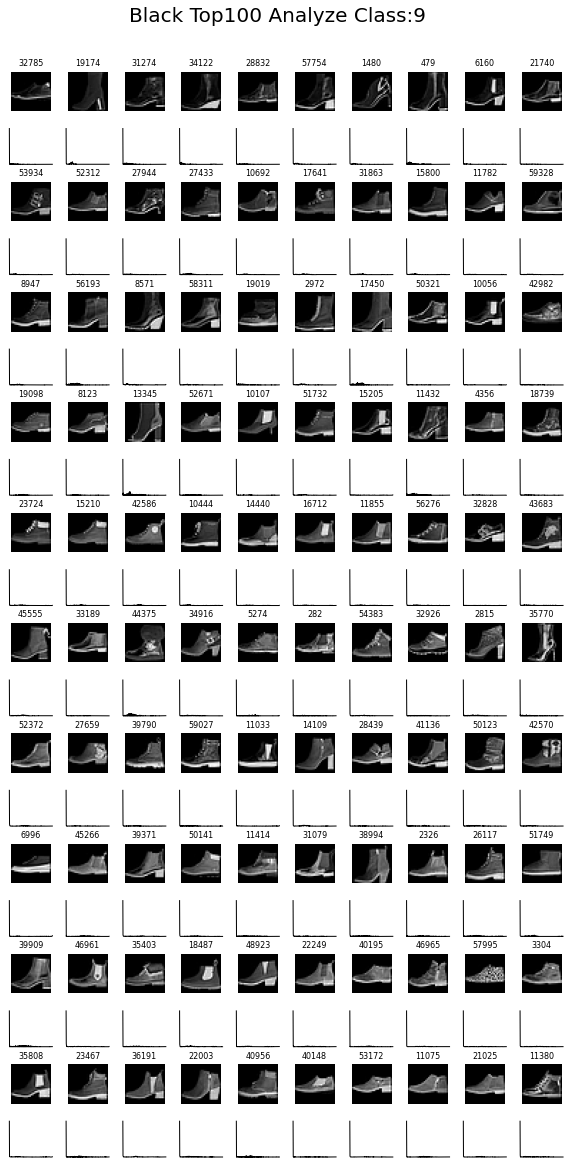

In [9]:
# 画素数上位/下位10の表示

for c in classes:
    indexes = get_top_index(np.array(target_means[c]), K=100)
    total_indexes = [target_indexes[c][i] for i in indexes]
    plot_image_and_hist(X_target, total_indexes, prefix='White Top100', n_class=c)

for c in classes:
    indexes = get_bottom_index(np.array(target_means[c]), K=100)
    total_indexes = [target_indexes[c][i] for i in indexes]
    plot_image_and_hist(X_target, total_indexes, prefix='Black Top100', n_class=c)

# for c in classes:
#     indexes = get_top_index(np.array(target_means[c]), K=10)
#     total_indexes = [target_indexes[c][i] for i in indexes]
#     # 画像
#     plot_image(X_target, total_indexes)
#     # 画像ヒストグラム
#     plot_hist_image(X_target, total_indexes)

# for c in classes:
#     indexes = get_bottom_index(np.array(target_means[c]), K=10)
#     total_indexes = [target_indexes[c][i] for i in indexes]
#     # 画像
#     plot_image(X_target, total_indexes)
#     # 画像ヒストグラム
#     plot_hist_image(X_target, total_indexes)


In [10]:
# # 主成分分析
# import pandas as pd 
# from sklearn.decomposition import PCA

# # # 可視化のためにデータフレームに変換
# # df = pd.DataFrame(X_train)
# # df["label"] = y_train
# # df.head()

# # 8次元に圧縮するPCAインスタンスを作成
# pca = PCA(n_components=8)
# # PCAで次元圧縮
# transformed = pca.fit_transform(X_train)

# # # 可視化のためにデータフレームに変換
# # embed3 = pd.DataFrame(transformed)
# # embed3["label"] = df["label"]                 
# # embed3.head()

# plt.scatter(transformed[:,0],transformed[:,1],s=3,c=y_train,cmap='tab10')
# plt.colorbar()
# plt.xlabel("PC1")
# plt.ylabel("PC2")


In [11]:
# 時間かかかるためスキップ
# # t-SNEによる可視化

# from sklearn.manifold import TSNE
# import time

# tsne = TSNE(n_components=2)
# t1 = time.time() 
# transformed = tsne.fit_transform(X_train)
# t2 = time.time()
# print(f"経過時間：{t2-t1}")
# plt.scatter(transformed[:,0],transformed[:,1],s=3,c=y_train,cmap='tab10')
# plt.colorbar()

In [12]:
# 時間かかかるためスキップ
# # UMAPによる可視化
# # http://mbd.riken.jp/VAE/lecture.html
# !pip install umap-learn

# import umap
# import warnings
# warnings.filterwarnings('ignore') #warningが出るので無視するようにしてしまっている

# from scipy.sparse.csgraph import connected_components


# print(umap)

# t1 = time.time() 
# result = umap.UMAP(n_neighbors=5, n_components=2).fit(X_train)
# t2 = time.time()
# print(f"経過時間：{t2-t1}")

# plt.figure(figsize=(6,5))
# plt.scatter(result.embedding_[:,0],result.embedding_[:,1],s=3,c=y_train, cmap='tab10')
# plt.colorbar()

In [13]:
# 画像ヒストグラム

# for c in classes:
#     indexes = get_top_index(np.array(train_means[c]), K=10)
#     total_indexes = [train_indexes[c][i] for i in indexes]
    
#     plot_image(X_train, total_indexes)
#     # 画像ヒストグラム
#     plot_hist_image(X_train, total_indexes)

#     indexes = get_bottom_index(np.array(train_means[c]), K=10)
#     total_indexes = [train_indexes[c][i] for i in indexes]
#     plot_image(X_train, total_indexes)



# indexes = get_top_index(np.array(train_means[0]), K=10)
# total_indexes = [train_indexes[c][i] for i in indexes] 
    
# # 画像の読み込み
# img = X_train[total_indexes[0]]


# mean = img.mean()
# print(mean)

# print(len(np.where(img > mean)[0]))
# print(len(np.where(img <= mean)[0]))


# # w = np.array(
# #     [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
# #      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]
# #      ) # 重みを設定。

# # 画像中央を重視する重みを設定。
# average_weight = np.array(
#     [[0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
#      [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
#      [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
#      [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
#      [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
#      [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
#      [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
#      [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
#      [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
#      [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
#      [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
#      [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
#      [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4],
#      [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4],
#      [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4],
#      [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4],
#      [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
#      [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
#      [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
#      [0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3],
#      [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
#      [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
#      [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
#      [0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2],
#      [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
#      [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
#      [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1],
#      [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1]]
#      )

# mean = np.average(img, weights=average_weight.flatten())
# print(mean)

# print(len(np.where(img > mean)[0]))
# print(len(np.where(img <= mean)[0]))

# # plt.imshow(img.reshape(28, 28), cmap = "gray")
# # plt.show()

# # #ヒストグラムの取得、表示
# # img_hist, _ = np.histogram(img, bins=np.arange(256+1))
# # plt.plot(img_hist)
# # plt.show()


In [14]:
   
# # 標準偏差（上位）
# for c in classes:
#     std_list = [np.std(X_train[i]) for i in train_indexes[c]]

#     # 降順にソートし、インデックスを取得
#     indices = np.argsort(-np.array(std_list))

#     plot_image(X_train, train_indexes[c][indices][0:10])
    
#     # 画像ヒストグラム
#     plot_hist_image(X_train, train_indexes[c][indices][0:10])

    
# # 標準偏差（下位）
# for c in classes:
#     std_list = [np.std(X_train[i]) for i in train_indexes[c]]

#     # 昇順にソートし、インデックスを取得
#     indices = np.argsort(std_list)

#     plot_image(X_train, train_indexes[c][indices][0:10])

#     # 画像ヒストグラム
#     plot_hist_image(X_train, train_indexes[c][indices][0:10])


In [15]:
# !pip install networkx

# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from mpl_toolkits.mplot3d import Axes3D

# # G に サッカーボルー型のグラフデータを格納する処理
# # エッジデータを生成
# edge_list = [
#     (0, 1), (1, 2), (2, 3), (3, 4), (4, 0),
#     (0, 5), (1, 6), (2, 7), (3, 8), (4, 9),
#     (5, 10), (10, 11), (11, 6), (6, 12), (12, 13),
#     (13, 7), (7, 14), (14, 15), (15, 8), (8, 16),
#     (16, 17), (17, 9), (9, 18), (18, 19), (19, 5),
#     (11, 20), (20, 21), (21, 12), (13, 22), (22, 23),
#     (23, 14), (15, 24), (24, 25), (25, 16), (17, 26),
#     (26, 27), (27, 18), (19, 28), (28, 29), (29, 10),
#     (21, 30), (30, 31), (31, 22), (23, 32), (32, 33),
#     (33, 24), (25, 34), (34, 35), (35, 26), (27, 36),
#     (36, 37), (37, 28), (29, 38), (38, 39), (39, 20),
#     (31, 40), (40, 41), (41, 32), (33, 42), (42, 43),
#     (43, 34), (35, 44), (44, 45), (45, 36), (37, 46),
#     (46, 47), (47, 38), (39, 48), (48, 49), (49, 30),
#     (41, 50), (50, 42), (43, 51), (51, 44), (45, 52),
#     (52, 46), (47, 53), (53, 48), (49, 54), (54, 40),
#     (50, 55), (51, 56), (52, 57), (53, 58), (54, 59),
#     (55, 56), (56, 57), (57, 58), (58, 59), (59, 55),
# ]

# # 生成したエッジデータからグラフ作成
# G = nx.Graph()
# G.add_edges_from(edge_list)

# # ノードの座標を固定
# pos = nx.spring_layout(G, dim=3)
# # 辞書型から配列型に変換
# pos_ary = np.array([pos[n] for n in G])

# # plot する figureと、 Axesを準備する
# fig = plt.figure(figsize=(10, 10), facecolor="w")
# ax = fig.add_subplot(111, projection="3d")


# # Axes にGraph をプロットする関数を準備
# def plot_graph():
#     ax.scatter(
#         pos_ary[:, 0],
#         pos_ary[:, 1],
#         pos_ary[:, 2],
#         s=200,
#     )

#     # ノードにラベルを表示する
#     for n in G.nodes:
#         ax.text(*pos[n], n)

#     # エッジの表示
#     for e in G.edges:
#         node0_pos = pos[e[0]]
#         node1_pos = pos[e[1]]
#         xx = [node0_pos[0], node1_pos[0]]
#         yy = [node0_pos[1], node1_pos[1]]
#         zz = [node0_pos[2], node1_pos[2]]
#         ax.plot(xx, yy, zz, c="#aaaaaa")


# # 引数を受け取って図を回転させる関数を準備
# def plt_graph3d(angle):
#     ax.view_init(azim=angle*5)


# # アニメーションを作成
# ani = FuncAnimation(
#     fig,
#     func=plt_graph3d,
#     frames=72,
#     init_func=plot_graph,
#     interval=300
# )

# # imagemagickで作成したアニメーションをGIFで書き出す
# ani.save("rolling.gif", writer="pillow")

In [18]:
!pip freeze

absl-py==0.9.0
argon2-cffi==20.1.0
asn1crypto==0.24.0
astunparse==1.6.3
attrs==20.1.0
backcall==0.2.0
bleach==3.1.5
cachetools==4.1.1
certifi==2020.6.20
cffi==1.14.2
chardet==3.0.4
cryptography==2.1.4
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
entrypoints==0.3
gast==0.3.3
google-auth==1.19.2
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
grpcio==1.30.0
h5py==2.10.0
idna==2.6
importlib-metadata==1.7.0
ipykernel==5.3.4
ipython==7.16.1
ipython-genutils==0.2.0
jedi==0.17.2
Jinja2==2.11.2
joblib==0.16.0
json5==0.9.5
jsonschema==3.2.0
jupyter-client==6.1.7
jupyter-core==4.6.3
jupyterlab==2.2.6
jupyterlab-server==1.2.0
Keras-Preprocessing==1.1.2
keyring==10.6.0
keyrings.alt==3.0
kiwisolver==1.2.0
Markdown==3.2.2
MarkupSafe==1.1.1
matplotlib==3.3.1
mistune==0.8.4
nbconvert==5.6.1
nbformat==5.0.7
notebook==6.1.3
numpy==1.18.5
oauthlib==3.1.0
opt-einsum==3.3.0
packaging==20.4
pandas==1.1.1
pandocfilters==1.4.2
parso==0.7.1
pexpect==4.8.0
pickleshare==0.7.5
Pillow==7.2.0
prometheus-client